# Proposed methodology for landscape analysis using Kereru as an example
## Jennifer Pannell 14.12.2018, AUT, for Farming Nature Conservation project RA4

This methodology has been adapted from Albert et al (2017), Hodgson et al (2016), Fortuna et al (2005), and is an example of the kinds of spatial networks we could generate for our study species and scenarios (birds, bats & pests). I think we could also bring bipartite species networks into this depending on the level of plant data we can generate for the landscapes. 

The main idea here is to describe the spatial arrangement of the landscape from the point of view of a kereru, in terms of its movement and home range, and to generate some statistics that we can compare between scenarios to infer resilience/function. I chose kereru because we have the most data for this species. 

Data needed to generate these models are:
1. Species movement and home range data
2. LCDB land cover data
3. Agribase farm data
4. LUCAS land use data
5. Road centrelines

Models were developed in ArcMap 10 and networks created using the Circuitscape ArcGIS toolbox. Network properties analysed in R using 'network', 'igraph' and 'NetIndices' packages. If we go ahead with this method or a variation, I propose that we use python to automate this. This network took approximately 6 hours to run in Circuitscape - if we do this for all combinations of species and landscape scenarios it could be time-consuming, but shouldn't require special computing facilities.

## Step 1 - Creating general land use maps
**Aim: create a general land use raster with classes that are relevant to the habitat quality for species of interest.**

Why not just use existing layer? Because all existing layers (LCBD, Agribase, etc) are useful but none alone has complete info, all overly complicated or not quite what we want. What we want: native forest, plantation forest, pasture with trees, pasture with shrubs, pasture, horticulture/arable, open water, etc. 

* Define landscape - used 20km buffer around farm
* Clip LCDB by landscape
* Identity LCDB and Agribase - so each LCDB patch has a farm type and is split if falls in multiple farms
* Repeat identity for LUCAS
* Spatial join with roads
* Define land use classes:
    + GRASSLAND: Agribase - SHP, BEF, SNB, DAI, GOA, DEE, none, GRA, LIF, NEW, PIG, DRY or LCDB - High producing exotic grassland, low producing grassland, gorse/broom, matagouri/grey scrub, fernland
        - GRASSLAND WITH TREES: Grassland with LCBD/LUCAS forest classes
        - GRASSLAND WITH SHRUBS: Grassland with LCDB matagouri/fernland/shrubland classes
        - GRASSLAND NOT GRAZED: Grassland with LCDB sub alpine shrubland, or farm type none/NAT/NOF
        - GRAZED GRASSLAND: All other grassland
    + PLANTATION FOREST: Agribase -FOR, LCDB decidious hardwoods/forest-harvested/exotic forest, LUCAS planted forest pre 1990/post 1989 forest
    + NATIVE FOREST: LCDB - Broadleaved indigenous hardwoods/indigenous forest/manuka & kanuka/native forest, LUCAS - natural forest/grassland with woody biomass
    + OPEN WATER: LCDB - Lake or pond/river, LUCAS - Wetland open water
    + HORTICULTURE/ARABLE: LCDB - short-rotation cropland, Agribase - HOR, LUCAS - Cropland annual
    + SETTLEMENTS: LCDB - Built up area (settlement), LUCAS - settlements
    + BARE GROUND: LCDB - Gravel or rock
    + NATURAL EXOTIC FOREST: LCDB - Deciduous hardoowds/exotic forest and no previously defined land use
    + INDUSTRIAL: LCDB - surface mine or dump/transport infrastructure. Visual inspection of undefined areas - open areas with human activity e.g. sports fields. Also where LU = ungrazed grassland with road id > 0.
    + WETLAND: LCDB - herbaceous freshwater vegetation, LUCAS - Wetland vegetated non forest

![](images/TMN_landuse.jpg)

## Step 2 - Turn land use into a raster of habitat quality
Follows recommendations from Corridor Design Project (http://corridordesign.org) where suitability is a unitless variable specific to the species scaling from 0 - 100 with the following breaks:
* 0 no use at all
* 1 - 30 avoided
* 30 - 60 occasional use for non-breeding
* 60 - 80 consistent use for breeding
* 80 - 100 best habitat for survival and breeding

I reclassified land use as 100 x 100 m raster grid (based on LUCAS & LCDB user accuracy) according to knowledge of species requirements (very rough and we can change this later): 
* Native forest = 100
* Natural exotic forest = 80
* Plantation forest = 70
* Grassland with trees = 60
* Grassland with shrubs = 50
* Ungrazed grassland = 50
* Wetland = 30
* Horticulture/arable = 30
* Settlements = 30
* Grazed grassland = 20
* Industrial = 20
* Open water = 0
* Bare ground = 0

Then adjust suitability for edge effects and roads.
1. Extract roads with speed class >= 3, convert to 100m raster with weight 0 (not habitat). 
2. Buffer road feature layer by 150m make into raster with value 0.1 (10% reduction in habitat quality near roads)
3. In land use layer, select polygons with area < minimum home range size (20 ha DOC estimate) or too isolated (> 4620 m from nearest patch, maximum pasture crossing distance), make into raster with value 0.5 (50% reduction in suitability - if native forest, may visit and forage but not breed)
4. Create buffers of 150m around habitat >= 80, remove any < 20 ha (already reduced by 50%), turn into raster with value 0.1 (10% reduction in habitat quality around patch edges)

Then, create final habitat quality raster (100 x 100 m) - multiply initial raster by all habitat modifiers described above. If final habitat quality >= 60 it is classified as habitat. **Habitat patches then become nodes.** Ideally this step should be followed by validation against occurrences - only 6 observations in the area but not bad, all in or close to habitat. 

![](images/kereru_hab_quality.jpg)

## Step 3 - Make resistance surface
Each pixel is then given a value of 1 - 32 in geometric intervals, based on species knowledge about willingness to cross habitat type, physiological cost of movement across habitat type, and survival in habitat type. For example, kereru may be equally willing to cross pasture with shrubs as empty fields, but more resources and perching places in shrubs and possibly lower likelihood of predation by raptors reduce cost and increase survival. Similarly, they are happy to cross roads or use suburban areas but often get hit by cars or fly into windows (DOC estimates this dramatically decreases life expectancy), so roads and settlements were given the highest resistance values.
* Habitat = 0
* Too small/too disconnected patches = 1
* Forest non-habitat = 1
* Open non-human (wetland, alpine grassland, bare) = 2
* Pasture with trees = 2
* Pasture with shrubs = 8
* Horticulture/arable = 8
* Pasture grazed = 16
* Open human (industrial/roads) & settlements = 32


## Step 4 - Build network from resistance and habitat maps
Initially I intended to use the methods of Albert et al but they are actually not well described and the code is not available or reproducible. I tried a few different methods including built in ArcMap options, but decided on Circuitscape finally (https://circuitscape.org/). 

**Aim: To calculate the least cost paths across resistance surface between ALL habitat nodes within maximum gap crossing distance of species, then use the least cost paths as network edges for desriptive statistics.**

Circuitscape is a good tool for this but I found the latest version would crash consistently around calculation 4000 regardless of the run settings. If we go down this road, I may look into why, but I found the slightly older ArcMap toolbox worked fine.

I created the network using the Linkage Mapper Toolkit > Linkage Pathways Tool > Build Network and Map Linkages
* Inputs = core area feature class (habitat polygons) and resistance raster
* Settings = cost weighted & euclidean distances; drop corridors that intersect core areas; bounding circles buffer distance & maximum euclidean corridor distance = 5000 m (based on kereru max gap crossing). Might change this in future to max weight = pasture restistance x euclidean gap crossing distance. 

![](images/kereru_corridors.jpg)

## Step 5 - Descriptive network statistics in R
Using the CSV linktable produced in the output directory by the linkage mapper tool. Gives us a data frame of all links in the network, with their euclidean and cost weighted distances, and the two nodes that they run between.

In [8]:
dat<-read.csv("kru_linktable.csv", header=T) # these are all network links & their distances

# remove inactive links (within core habitat patches or greater than max cwd/euc distance)
dat<-subset(dat, linkType>0)

Ran some descriptive stats using dfSummary: 
* n links = 587 
* euc dist - left skewed, mean 908 +/- 1080 sd, min = 12, max = 4910 
* lc dist - left skewed, mean = 9048 +/- 13906 sd, min = 141, max = 85518
* lc length - left skewed, mean = 1200 +/- 1370 sd, min = 141, max = 6642
* cwd:eucD - 0 inflated l skewed, mean = 6.84 +/- 6.31 sd, min= 1.12, max = 37.29
* cwd:path - v 0 inflated, mean = 4.85 +/- 4.79, min = 1, max = 24.25


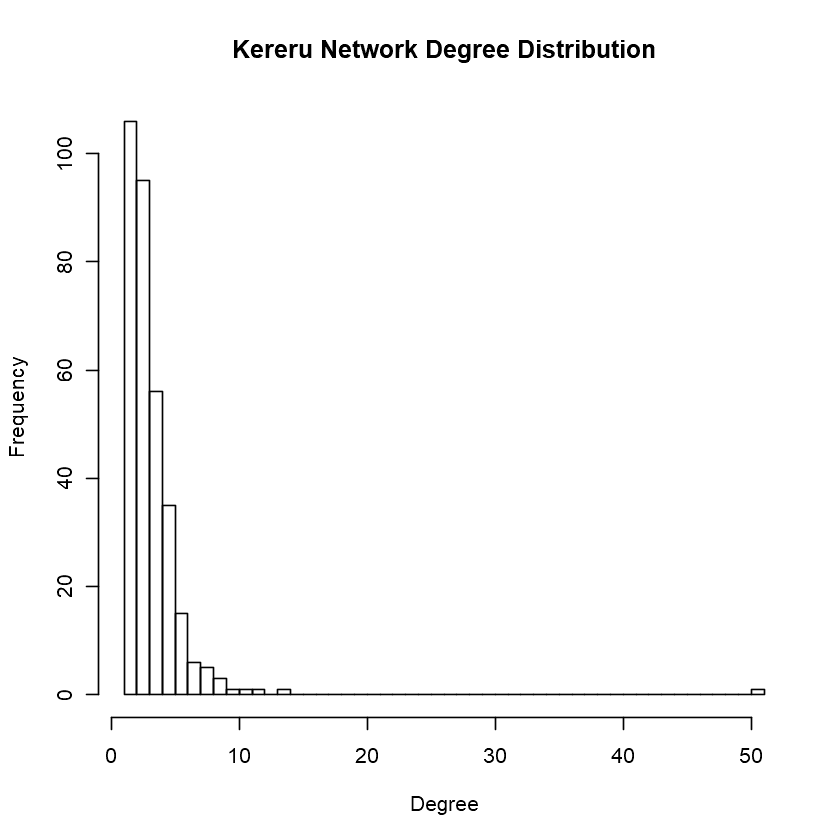

In [7]:
# degree distribution ####
nodes<-c(1:438) # select all nodes/patches
links<-rep(0, length(nodes)) # make empty vector for writing the number of links per node
dd<-data.frame(nodes, links)

# for each node, count how many links it has going into or coming out of it
for (i in 1:nrow(dd)) {
  a<-dd$nodes[i]
  dd$links[i]<-(length(which(dat$coreId1==a))+length(which(dat$coreId2==a)))
  rm(a)
}

dd<-subset(dd, links>0) # some patch IDs don't exist as they were removed early on for being too small
hist(dd$links, breaks=max(dd$links), xlab="Degree", main="Kereru Network Degree Distribution")


This tells us that there's one **really** important patch (it's the huge one) with 51 links, but majority have relatively few. This appears to roughly follow a power law - these types of networks are robust to losing random nodes but very vulnerable to the loss of just one or a few key nodes.

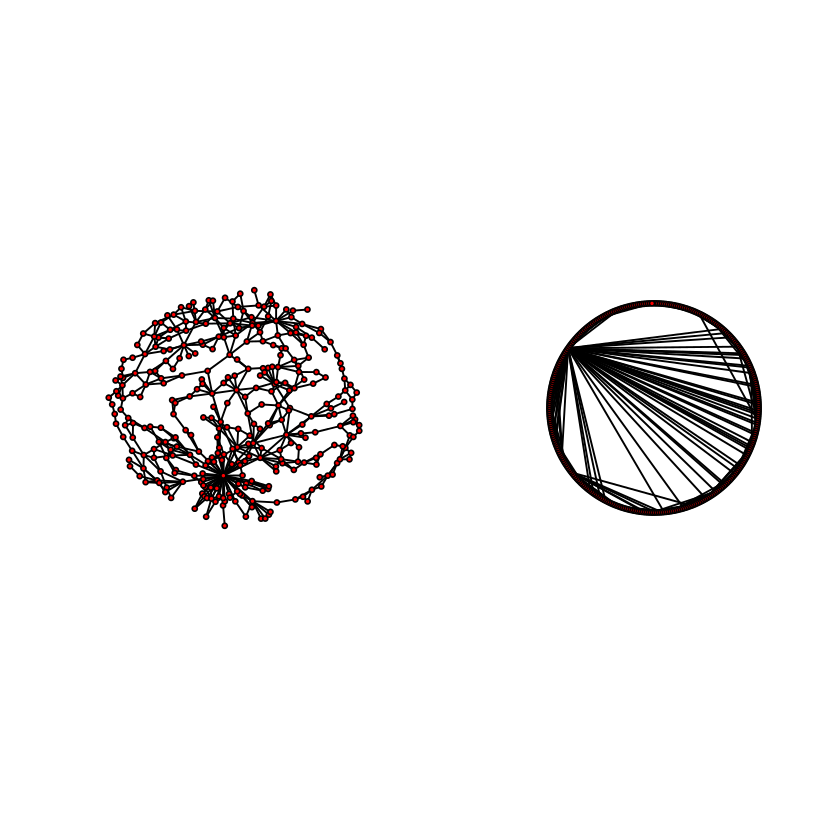

In [10]:
# network plots ####
library(tidyverse, quietly=TRUE)
# select just the edge/link start and end nodes
edge_list<-data.frame(dat$coreId1, dat$coreId2) 
class(edge_list[[1]])<-"integer"
class(edge_list[[2]])<-"integer"
edge_list<-rename(edge_list, coreId1=dat.coreId1, coreId2=dat.coreId2)

# rename edge start/end points by the row number, because of the fact some node IDs don't exist as seen in previous block - this is just an annoying thing that the network plots can't cope with
for (i in 1:nrow(edge_list)) {
  a<-edge_list$coreId1[i]
  b<-edge_list$coreId2[i]
  edge_list$from[i]<-which(dd$nodes==a)
  edge_list$to[i]<-which(dd$nodes==b)
  rm(a,b)
}

edge_list<-edge_list[c(3:4)]

node_list<- c(1:length(dd$nodes)) %>%
    data.frame() %>%
    rename(nodes = ".")

library(network)

kru_network<-network(edge_list, vertex.attr=node_list, matrix.type="edgelist", 
                     ignore.eval=FALSE, directed=FALSE)

# plot the network diagrams
par(mfrow=c(1,2))
plot(kru_network)
plot(kru_network, mode="circle")

[1] "-0.0174329202045112 : a slightly dis-associative network"

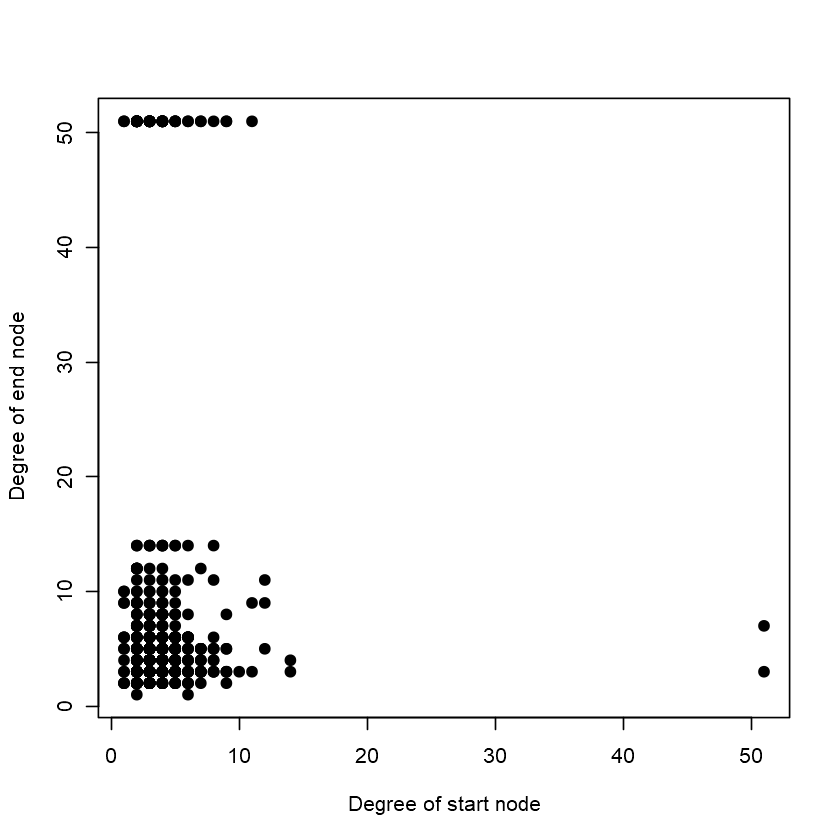

In [34]:
# degree correlation ####
# do highly connected nodes tend to be connected to each other? Is network associative or dis-associative?

# add the degree of each to/from node to the original data frame
for (i in 1:nrow(dat)) {
  a<-dat$coreId1[i]
  b<-dat$coreId2[i]
  dat$ddcore1[i]<-dd$links[match(a, dd$nodes)]
  dat$ddcore2[i]<-dd$links[match(b, dd$nodes)]
  rm(a,b)
}

par(mfrow=c(1,1))
plot(dat$ddcore1, dat$ddcore2, xlab = "Degree of start node", ylab = "Degree of end node", pch=19)
correl<-cor(dat$ddcore1, dat$ddcore2)
paste(correl,": a slightly dis-associative network")
rm(correl)

In [26]:
## some network properties with igraph & NetIndices ####
## code from https://assemblingnetwork.wordpress.com/2013/06/10/network-basics-with-r-and-igraph-part-ii-of-iii/

library(igraph, quietly=TRUE)
library(NetIndices, quietly=TRUE)

kru.ig<-graph_from_data_frame(d=edge_list, vertices=node_list, directed=FALSE)
kru.ig.adj<-get.adjacency(kru.ig, sparse=F)

properties<-GenInd(kru.ig.adj)

paste(properties$N, ": number of nodes")
paste(properties$Ltot, ": number of links - twice number of edges b/c they are bidirectional")
paste(properties$LD, ": link density")
paste(properties$C, " : connectance")

[1] "326 : number of nodes"

[1] "1174 : number of links - twice edges b/c they are bidirectional"

[1] "3.60122699386503 : link density"

[1] "0.0110806984426616  : connectance"

In [29]:
kru.ig.deg<-degree(kru.ig,v=V(kru.ig),mode="all")
power<-power.law.fit(kru.ig.deg)

# The output of the power.law.fit() function tells me what the exponent of the power law is ($alpha)
# and the log-likelihood of the parameters used to fit the power law distribution ($logLik)
# Also, it performs a Kolmogov-Smirnov test to test whether the given degree distribution could have
# been drawn from the fitted power law distribution.
# The function thus gives me the test statistic ($KS.stat) and p-vaule ($KS.p) for that test

power
## in this case, ks = 0.03, p = 1, therefore can't reject h0 that it's power law, small score = good fit, 
## evidence of scalar network


$continuous
[1] FALSE

$alpha
[1] 4.314864

$xmin
[1] 5

$logLik
[1] -113.3858

$KS.stat
[1] 0.02618765

$KS.p
[1] 1

In [31]:
## How clustered is the network? ###
# Clustering coefficient, betweenness, and closeness
# all describe the small world properties of the network.
# A network with small world properties is one in which
# it takes a relatively short path to get from one node to the next

t<-transitivity(kru.ig)
paste(t, ": clustering coefficient of the whole network")

# then the clustering coefficient of each node
kt<-transitivity(kru.ig,type="local")
summary(kt)

[1] "0.205079962370649 : clustering coefficient of the whole network"

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
 0.0000  0.1786  0.3333  0.4461  0.6667  1.0000      19 

In [32]:
# Betweenness is the number of shortest paths between two nodes that go through each node of interest
graph.betweenness<-betweenness(kru.ig,v=V(kru.ig))
graph.edge.betweenness<-edge.betweenness(kru.ig,e=E(kru.ig))

summary(graph.betweenness)
summary(graph.edge.betweenness)

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
    0.000     0.833   193.746  1054.497  1130.192 26704.272 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    1.0   117.9   306.9   675.9   607.2  9864.8 

In [33]:
# Closeness refers to how connected a node is to its neighbors
graph.closeness<-closeness(kru.ig,vids=V(kru.ig))
summary(graph.closeness)

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
0.0002797 0.0003600 0.0004252 0.0004248 0.0004892 0.0006184 

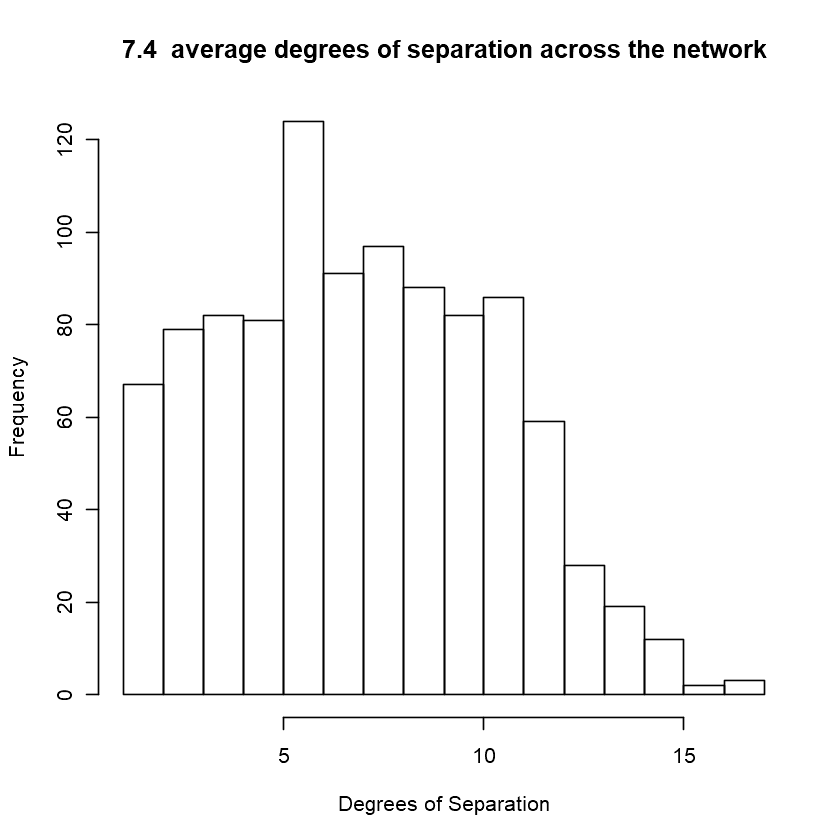

In [36]:
## Finally - how many degrees of separation in this network? ####
## for any randomly selected pair of nodes, what's the number of links in the shortest path between them

n<-1000 # how many bootstraps do you want
run<-c(1:n) 
distance<-rep(0, n)
baconframe<-data.frame(run, distance) # so named after the "6 degrees of Kevin Bacon"

# select a random pair of nodes in the network without replacement, calculate distance between them 
# i.e. how many links between the two nodes

for (i in 1:length(run)){
  a<-sample(1:nrow(node_list), 2, replace=F)
  n1<-a[1]
  n2<-a[2]
  bacon<-distances(kru.ig, v=n1, to=n2)
  baconframe$distance[i]<-bacon
  rm(a,n1,n2,bacon)
}

sep<-mean(baconframe$distance)
title<-paste(sep, " average degrees of separation across the network")

hist(baconframe$distance, breaks=20, xlab= "Degrees of Separation", main=title)
